### What is the most optimal skill to learn for Data Analysts?

Methodology:

1. Group skills to determine median salary & likelihood of being in postings (%)
2. Visualize median salary vs % skill demand
3. (Optional) Determine if certain technologies are more prevalent


In [1]:
from datasets import load_dataset
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading up data
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset["train"].to_pandas()

In [3]:
# Cleaning up data
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"])

### Regex Syntax

| Syntax (x) | Meaning                                                             | Example pattern | Example Matches           | Example Non-Matches    |
| ---------- | ------------------------------------------------------------------- | --------------- | ------------------------- | ---------------------- |
| r          | ???                                                                 |
|            | **Repetitions - Quantifiers**                                       |
| .          | any character except a newline                                      |
| x\*        | 0 or more repetitions                                               | ar\*o           | cac`ao` <br> c`arro`t     | arugula <br> artichoke |
| x+         | 1 or more repetitions                                               | re+             | g`ree`n <br> t`ree`       | trap <br> ruined       |
| x?         | 0 or 1 repetition                                                   | ro?a            | `roa`st <br> `ra`nt       | root <br> rear         |
| x{m}       | m repetitions                                                       | \we{2}\w        | `deer` <br> `seer`        | red <br> enter         |
| x{m,}      | >= m repetitions                                                    | 2{3,}4          | 671-`2224` <br> `2222224` | 224 <br> 123           |
|            | **Lookahead & Lookbehind** (fixed width means no use of quantifier) |
| (?<=x)     | looks at previous characters for a match                            | (?<=tr)a        | tr`a`il <br> tr`a`nslate  | bear <br> streak       |
| (?!x)      | looks ahead at next characters to NOT match on                      | ai(?!n)         | f`ai`l <br> br`ai`l       | faint <br> train       |
| (?<!x)     | looks at previous characters to NOT match on                        | (?<!tr)a        | be`a`r <br> transl`a`te   | trail <br> strained    |

[CS50P 2022 materials](https://cs50.harvard.edu/python/2022/weeks/) <br>
[Regex Test tool](https://regex101.com/) <br>
[DataCamp cheatsheet](https://www.datacamp.com/cheat-sheet/regular-expresso) <br>
[DataQuest cheatsheet](https://www.dataquest.io/cheat-sheet/regular-expressions-cheat-sheet/)


In [4]:
import re

# test for corner cases with ' as a possessive apostrophe or short form of a word
test_str = "{'stuff': {'stuffy': ['a mother's love','my sisters' friends', 'lots more stuffs'',''tis the season', 'wait 'til he came']}}"
test_str = re.sub(r"(?<![a-zA-Z0-9 '])'|'(?![a-zA-Z0-9 '])|(?<=, )'", '"', test_str)
print(test_str)
print(json.loads(test_str))

{"stuff": {"stuffy": ["a mother's love","my sisters' friends", "lots more stuffs'","'tis the season", "wait 'til he came"]}}
{'stuff': {'stuffy': ["a mother's love", "my sisters' friends", "lots more stuffs'", "'tis the season", "wait 'til he came"]}}


In [5]:
# myself: NOT DONE. KEEP FOR TRYING LATER
re.sub(
    r"('.+':s\[('.+')+,*\])+", r"(\".+\":s\[(\".+\")+,*\])+", df["job_type_skills"][1]
)

"{'analyst_tools': ['power bi', 'tableau'], 'programming': ['r', 'python', 'sql', 'nosql']}"

In [6]:
# Remove outer str quotes from list-like & dict-like columns by using RegEx to convert str to JSON format then applying json.loads() to remove outer str quotes. Much faster method than ast.literal_eval()
def convert_types(element):
    if not isinstance(element, (list, dict)):
        return json.loads(
            re.sub(r"(?<![a-zA-Z0-9 '])'|'(?![a-zA-Z0-9 '])|(?<=, )'", '"', element)
        )
    else:
        return element


df[["job_skills", "job_type_skills"]] = df[["job_skills", "job_type_skills"]].map(
    convert_types, na_action="ignore"
)

In [7]:
# Filter for data analyst jobs in the US then clean up data
df_DA_US = df.loc[
    (df["job_title_short"] == "Data Analyst") & (df["job_country"] == "United States")
].copy()
df_DA_US.dropna(subset="salary_year_avg", inplace=True)
df_DA_US_explode = df_DA_US.explode("job_skills", ignore_index=True)

## Add new column for assigning technology category for each skill


#### Using `.apply()` is slower than `map()`

```python
def match_technology(row):
    if isinstance(row["job_type_skills"], dict):
        for key, value in row["job_type_skills"].items():
            if row["job_skills"] in value:
                return key


df_DA_US_explode["technology"] = df_DA_US_explode.apply(match_technology, axis=1)
```


### Faster alternative to `.apply()` is `map()`

`.map()` can't be used directly with multiple columns when calculating for each column is different as it applies a function ELEMENTWISE to the iterator whereas `.apply()` applies a function ALONG/ACROSS an AXIS, meaning: when `.map()` is applied to a DataFrame (or a subset of columns), it operates on **columns** rather than rows. This means function will receive **column names as arguments**, not row data.

So to work with multiple columns simultaneously, you would need a method that can access and process data from multiple columns within each row such as converting to a list/tuple.


In [8]:
#### Option 1: convert columns into a list to pass in function
def match_technology(job_skill, job_type_skill):
    if isinstance(job_type_skill, dict):
        for key, value in job_type_skill.items():
            if job_skill in value:
                return key
    else:
        return job_type_skill


df_DA_US_explode["technology"] = list(
    map(
        match_technology,
        df_DA_US_explode["job_skills"],
        df_DA_US_explode["job_type_skills"],
    )
)

#### Option 2: Convert columns to a tuple/list then unpack them within function

```python
def match_technology(row):
    job_skill, job_type_skill = row  # Unpack the tuple
    if isinstance(job_type_skill,dict):
        for key, value in job_type_skill.items():
            if job_skill in value:
                return key
    else:
        return job_type_skill

# Combine the columns into a Series of tuples
skill_type_tuples = pd.Series(
    zip(df_DA_US_explode["job_skills"], df_DA_US_explode["job_type_skills"])
)

# Apply the function using map
df_DA_US_explode["technology"] = skill_type_tuples.map(
    match_technology, na_action="ignore"
)
```


#### Option 3: Zipping DataFrame's columns into tuple/list then applying function as a list comprehension

```python
df["d"] = [some_func(*a) for a in tuple(zip(df["a"], df["b"], df["c"]))]
```

Further optimized by removing the tuple instantiation:

```python
df["d"] = [some_func(*a) for a in zip(df["a"], df["b"], df["c"])]
```


```python
def match_technology(job_skill, job_type_skill):
    if isinstance(job_type_skill, dict):
        for key, value in job_type_skill.items():
            if job_skill in value:
                return key
    else:
        job_type_skill


df_DA_US_explode["technology"] = [
    match_technology(job_skill, job_type_skill)
    for job_skill, job_type_skill in zip(
        df_DA_US_explode["job_skills"], df_DA_US_explode["job_type_skills"]
    )
]
```


#### Option 4: A even faster way to `map()` multiple columnns is to use `frompyfunc` from `numpy` to create a vectorized version of the python function

```python
import numpy as np
some_func_vec = np.frompyfunc(some_func, 3, 1)
df["d"] = some_func_vec(df["a"], df["b"], df["c"])
```


#### Option 5 (Slowest: 2s): Apply `.map()` to the DataFrame's index

```python
def match_technology(row):
    job_skill = row["job_skills"]
    job_type_skill = row["job_type_skills"]

    if isinstance(job_type_skill, dict):
        for key, value in job_type_skill.items():
            if job_skill in value:
                return key
    return job_type_skill
# Apply the function using map on the DataFrame's index
df_DA_US_explode["technology"] = df_DA_US_explode.index.map(
    lambda index: match_technology(df_DA_US_explode.loc[index])
)
```


In [9]:
# Group by job_skills for calculating skill count & median salary
df_DA_US_skills = (
    df_DA_US_explode.groupby(["job_skills", "technology"])
    .agg(
        skill_count=("job_skills", "count"), median_salary=("salary_year_avg", "median")
    )
    .sort_values("skill_count", ascending=False)
    .reset_index(level=1)
)

In [10]:
# Calculate percent of skill count to total job posts
df_DA_US_skills["skill_percent"] = df_DA_US_skills["skill_count"] / len(df_DA_US)
df_DA_US_skills

,technology,skill_count,median_salary,skill_percent
job_skills,,,,
sql,programming,2508,91000.0,0.576552
excel,analyst_tools,1808,84392.0,0.415632
python,programming,1431,97500.0,0.328966
tableau,analyst_tools,1364,92875.0,0.313563
sas,analyst_tools,926,90000.0,0.212874
...,...,...,...,...
couchbase,databases,1,160515.0,0.000230
chainer,libraries,1,100000.0,0.000230
chef,other,1,85000.0,0.000230


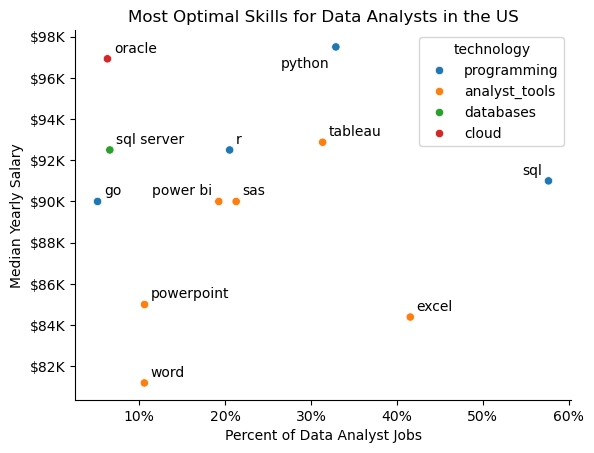

In [11]:
# Filter top skills for plotting
skill_percent = 0.05
df_DA_US_skills_top = df_DA_US_skills.loc[
    df_DA_US_skills["skill_percent"] > skill_percent
]
sns.scatterplot(
    df_DA_US_skills_top, x="skill_percent", y="median_salary", hue="technology"
).set(
    xlabel="Percent of Data Analyst Jobs",
    ylabel="Median Yearly Salary",
    title="Most Optimal Skills for Data Analysts in the US",
)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"${y/1000:,.0f}K"))
sns.despine()

import textalloc as ta  # add annotation text & prevent it from overlapping

ta.allocate(
    plt.gca(),
    df_DA_US_skills_top["skill_percent"],
    df_DA_US_skills_top["median_salary"],
    df_DA_US_skills_top.index,
    draw_lines=False,
)
plt.show()

[`plt.text()` vs `ax.annotate()`?](https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html) <br>
[Remove annotation from overlapping](https://stackoverflow.com/questions/19073683/how-to-fix-overlapping-annotations-text) <br>
[**Seaborn Objects** (WIP) for automatically adding annotation](https://seaborn.pydata.org/tutorial/objects_interface.html) <br>
[seaborn.objects.Text() method](https://seaborn.pydata.org/generated/seaborn.objects.Text.html)


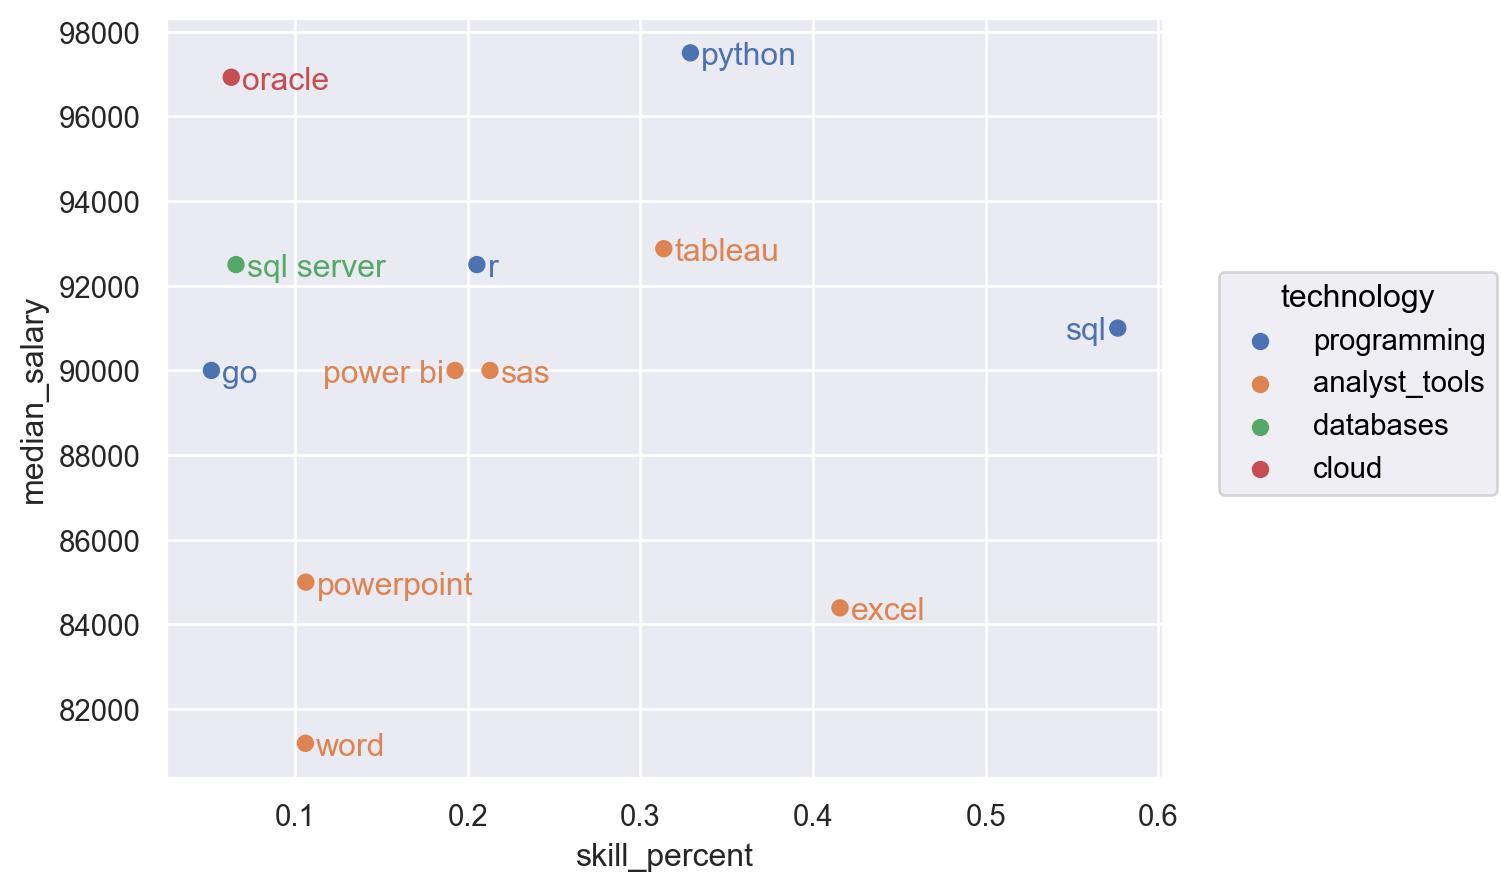

In [ ]:
import seaborn.objects as so  # Try out new WIP seaborn system

so.Plot(
    df_DA_US_skills_top,
    "skill_percent",
    "median_salary",
    text="job_skills",
    color="technology",
).add(so.Dot()).add(so.Text(), halign="job_skills").scale(
    halign={  # manually adjust annotation text from overlapping
        job_skill: "right" if job_skill in ["power bi", "sql"] else "left"
        for job_skill in df_DA_US_skills_top.index
    }
)